In [1]:
import os #change directory
import pandas as pd #work on dataframe
import numpy as np # Work on null values
import matplotlib.pyplot as plt  #plot charts
import seaborn as sns
from datetime import datetime, timedelta   #Manipulating 'dteday'
from sklearn.preprocessing import StandardScaler    #Rescaling
from sklearn.model_selection import train_test_split  #Train-test split
import statsmodels.api as sm  #Model building
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor  #Calculating VIF
from sklearn import metrics  # Model evaluation

In [2]:
os.chdir('C:\\Users\\jaxer\\Downloads')  #Change directory

In [3]:
df= pd.read_csv('day.csv') #import the dataset

# Data understanding and EDA


1. Droping unnecessary variables

- The variable 'instant' will not add value into model building.
- The variables 'casual', 'registered' and 'cnt' are redundant so it will be advisable to choose cnt, which stands for the count of total rental bikes including both casual and registered, as the target variable.
- The variables 'temp' and 'atemp' are also representing similar aspects. When people ride bikes, the feeling temperature will be more related to them. Thus, we will drop 'temp'
- The variable 'dteday' reflects almost the same info contained in other variables such as 'yr' and 'mnth'. However, understanding the week of the month will be beneficial to our model simply because people frequently run out of money at the end of month and thus choose to ride a bike rather than other expensive means. Therefore, we drop the variable 'dteday' and create a variable 'wom' showing the week of the month. 


In [4]:
df.drop(['instant', 'temp', 'casual', 'registered'], axis=1, inplace=True)   #Drop variables

In [5]:
df['dteday'] = pd.to_datetime(df['dteday']) #change the variable to datetime

def week_of_month(date):                   #Define a function calculating week of month
    month = date.month
    week = 0
    while date.month == month:
        week += 1
        date -= timedelta(days=7)

    return week
df['wom'] = df.dteday.apply(week_of_month)  #Create a variable representing week of month
df.drop(['dteday'], axis=1, inplace= True)  # Drop 'dteday'

2. Checking missing value, data types, and outliers

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    int64  
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    int64  
 7   atemp       730 non-null    float64
 8   hum         730 non-null    float64
 9   windspeed   730 non-null    float64
 10  cnt         730 non-null    int64  
 11  wom         730 non-null    int64  
dtypes: float64(3), int64(9)
memory usage: 68.6 KB


In [7]:
# Find out the percentage of missing values in each column
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df

,column_name,percent_missing
season,season,0.0
yr,yr,0.0
mnth,mnth,0.0
holiday,holiday,0.0
weekday,weekday,0.0
workingday,workingday,0.0
weathersit,weathersit,0.0
atemp,atemp,0.0
hum,hum,0.0
windspeed,windspeed,0.0


[Text(0.5, 0, 'cnt')]

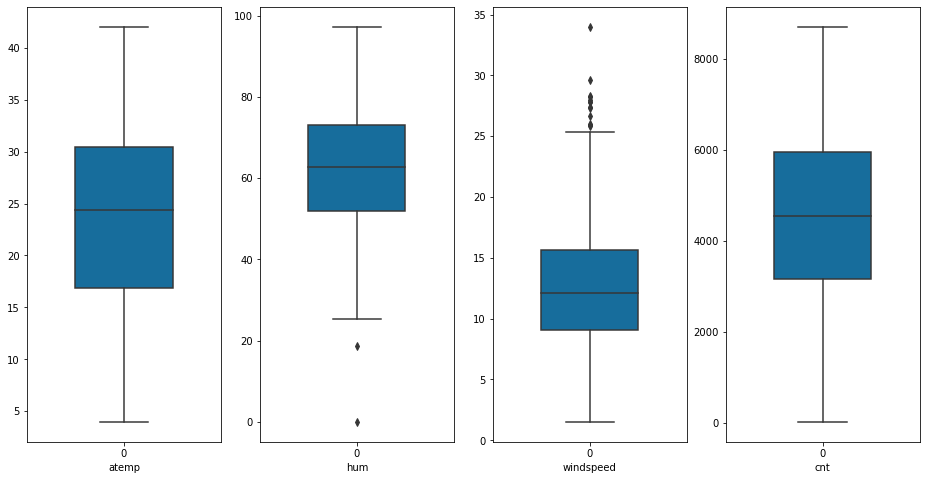

In [8]:
fig, axes = plt.subplots(1, 4, figsize=(16,8))  #Create subplots
#Plot boxplots for variables
sns.boxplot(ax=axes[0],data=df.atemp, width=0.5,palette="colorblind").set(xlabel='atemp')
sns.boxplot(ax=axes[1],data=df.hum, width=0.5,palette="colorblind").set(xlabel='hum')
sns.boxplot(ax=axes[2],data=df.windspeed, width=0.5,palette="colorblind").set(xlabel='windspeed')
sns.boxplot(ax=axes[3],data=df.cnt, width=0.5,palette="colorblind").set(xlabel='cnt')

In [9]:
#Define a function removing outliers
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [10]:
# Remove outliers
df1=remove_outlier(df,'hum') 
df2=remove_outlier(df1,'windspeed')

For better interpretation, we will manipulate certain categorical variables

In [11]:
#For column season
df2.season = df2.season.replace(1, 'spring') \
.replace(2, 'summer') \
.replace(3, 'fall')\
.replace(4, 'winter')
#For column yr
df2.yr = df2.yr.replace(0, '2018') \
.replace(1, '2019') \
#For column mnth
df2.mnth = df2.mnth.replace(1, 'Jan') \
.replace(2, 'Feb') \
.replace(3, 'Mar')\
.replace(4, 'Apr')\
.replace(5, 'May')\
.replace(6, 'Jun')\
.replace(7, 'Jul')\
.replace(8, 'Aug')\
.replace(9, 'Sep')\
.replace(10, 'Oct')\
.replace(11, 'Nov')\
.replace(12, 'Dec')
#For weekday
df2.weekday = df2.weekday.replace(0, 'Mon')\
.replace(1, 'Tue')\
.replace(2, 'Wed')\
.replace(3, 'Thu')\
.replace(4, 'Fri')\
.replace(5, 'Sat')\
.replace(6, 'Sun')
#For weathersit
df2.weathersit = df2.weathersit.replace(1, 'weathersit1')\
.replace(2, 'weathersit2')\
.replace(3, 'Weathersit3')
#For wom
df2.wom = df2.wom.replace(1, 'week1') \
.replace(2, 'week2') \
.replace(3, 'week3')\
.replace(4, 'week4')\
.replace(5, 'week5')


C:\Python\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


3. Univariate Analysis on continuous variables (After binning)

Text(0.5, 0, 'cnt')

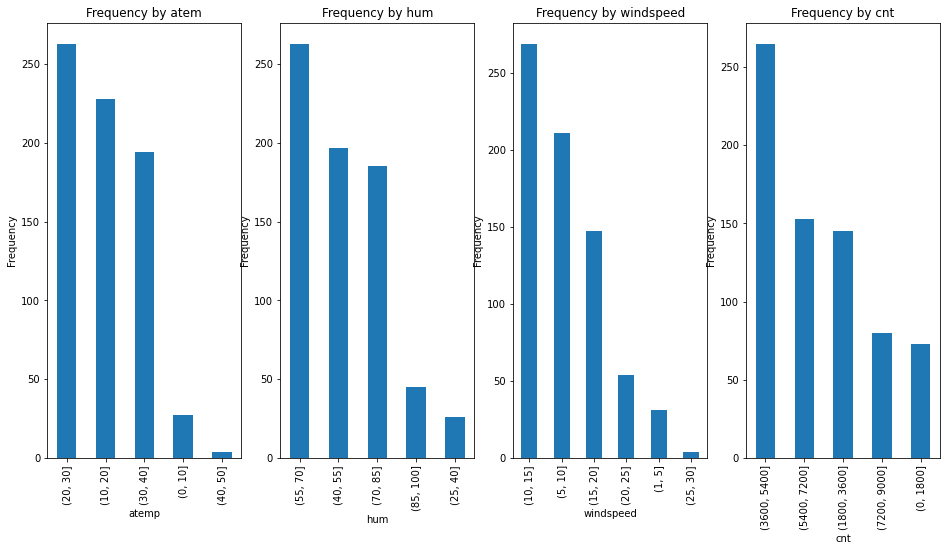

In [12]:
fig, axes = plt.subplots(1, 4, figsize=(16,8))  #Create subplots
#For the variable 'atemp'
plt.subplot(1, 4, 1)
bins1 = pd.cut(df2['atemp'], [0,10,20,30,40,50])   # Binning 
temp1=bins1.value_counts()
ax1=temp1.plot.bar()                          #BarPlot
ax1.set_title('Frequency by atem')           #set title
ax1.set_ylabel("Frequency")                  #set label
ax1.set_xlabel("atemp") 
#For the variable 'hum'
plt.subplot(1, 4, 2)
bins2 = pd.cut(df2['hum'], [25,40,55,70,85,100])   # Binning 
temp2=bins2.value_counts()
ax2=temp2.plot.bar()                          #BarPlot
ax2.set_title('Frequency by hum')           #set title
ax2.set_ylabel("Frequency")                  #set label
ax2.set_xlabel("hum") 
#For the variable 'windspeed'
plt.subplot(1, 4, 3)
bins3 = pd.cut(df2['windspeed'], [1,5,10,15,20,25,30])   # Binning 
temp3=bins3.value_counts()
ax3=temp3.plot.bar()                          #BarPlot
ax3.set_title('Frequency by windspeed')           #set title
ax3.set_ylabel("Frequency")                  #set label
ax3.set_xlabel("windspeed") 
#For the variable 'cnt'
plt.subplot(1, 4, 4)
bins4 = pd.cut(df2['cnt'], [0,1800,3600,5400,7200,9000])
temp4=bins4.value_counts()
ax4=temp4.plot.bar()                          #BarPlot
ax4.set_title('Frequency by cnt')           #set title
ax4.set_ylabel("Frequency")                  #set label
ax4.set_xlabel("cnt") 



# Insights:
- The feeling temperature mostly sits within 20~30. Cool or extremely high temperature rarely occurred.
- The humidity is commonly high with 55~70 occurred most. 
- Frequently we will see windspeed between 10~15/ Low windspeed or extremely high windspeed rarely occurred.
- The most common daily borrow amount is between 3600~5400


4. Univariate Analysis for categorical variable 


Text(0.5, 0, 'weathersit')

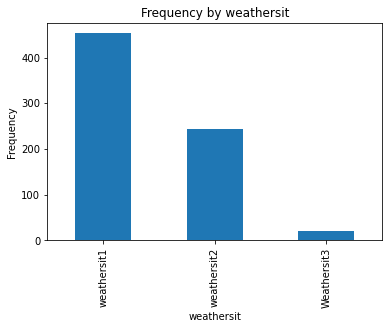

In [13]:
temp5= df2.weathersit.value_counts()
ax5=temp5.plot.bar()                          #BarPlot
ax5.set_title('Frequency by weathersit')           #set title
ax5.set_ylabel("Frequency")                  #set label
ax5.set_xlabel("weathersit") 


# Insight:
- Clear, Few clouds, Partly cloudy, Partly cloudy weather occurs most and light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds occurs least.

5. Bivariate Analysis for continuous variables

[Text(0.5, 1.0, 'cnt for windspeed')]

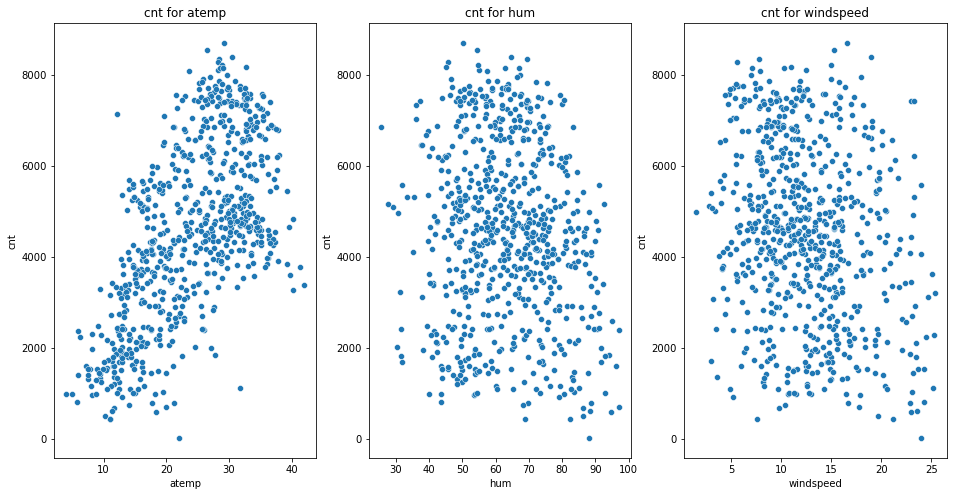

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(16,8))  #Create subplots
#For the variable 'atemp'
plt.subplot(1, 3, 1)
sns.scatterplot(data = df2, x = "atemp", y = 'cnt').set(title='cnt for atemp')
#For the variable 'atemp'
plt.subplot(1, 3, 2)
sns.scatterplot(data = df2, x = "hum", y = 'cnt').set(title='cnt for hum')
#For the variable 'atemp'
plt.subplot(1, 3, 3)
sns.scatterplot(data = df2, x = "windspeed", y = 'cnt').set(title='cnt for windspeed')


# Insight:
- From the scatterplot, we see a linear relationship between the variable atemp and our target variable cnt. However, There's no obvious relationship for the variable hum and windspped with regard to cnt. We will keep this in mind when building our model. 

6. Bivariate Analysis for categorical variable

Text(0.5, 1.0, 'cnt for different weathersit')

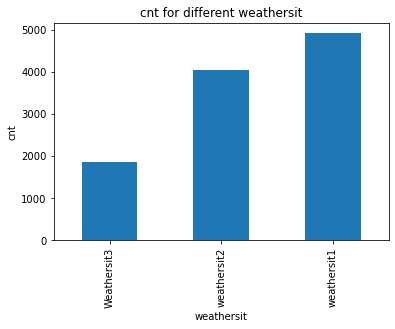

In [15]:
temp6=df2.groupby('weathersit')['cnt'].mean().sort_values() #Caulculate default rate by different issue months
ax6=temp6.plot.bar()                          #BarPlot
ax6.set_ylabel("cnt")               #Set labels
ax6.set_title('cnt for different weathersit')         #set title

# Insight:
- When weathersit is 1( Clear, Few clouds, Partly cloudy, Partly cloudy), the mean borrowed amount reaches its highest value. When weathersit is 3 (Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds), the mean borrowed amount reaches its lowest value.


# Insight:
-  atemp show strong correlation with cnt

7. One-hot Encoding

In [16]:
# For the variable 'season'
season = pd.get_dummies(df2['season'], drop_first = True)
# Add the results to the original dataframe
df2 = pd.concat([df2, season], axis = 1)
# Drop 'season' as we have created the dummies for it
df2.drop(['season'], axis = 1, inplace = True)

#For the variable 'yr'
year = pd.get_dummies(df2['yr'], drop_first = True)
# Add the results to the original dataframe
df2 = pd.concat([df2, year], axis = 1)
# Drop as we have created the dummies for it
df2.drop(['yr'], axis = 1, inplace = True)

#For the variable 'mnth'
month = pd.get_dummies(df2['mnth'], drop_first = True)
# Add the results to the original dataframe
df2 = pd.concat([df2, month], axis = 1)
# Drop as we have created the dummies for it
df2.drop(['mnth'], axis = 1, inplace = True)

#For the variable 'weekday'
weekday = pd.get_dummies(df2['weekday'], drop_first = True)
# Add the results to the original dataframe
df2 = pd.concat([df2, weekday], axis = 1)
# Drop as we have created the dummies for it
df2.drop(['weekday'], axis = 1, inplace = True)

#For the variable 'weathersit'
weathersit = pd.get_dummies(df2['weathersit'], drop_first = True)
# Add the results to the original dataframe
df2 = pd.concat([df2, weathersit], axis = 1)
# Drop as we have created the dummies for it
df2.drop(['weathersit'], axis = 1, inplace = True)

#For the variable 'wom'
wom = pd.get_dummies(df2['wom'], drop_first = True)
# Add the results to the original dataframe
df2 = pd.concat([df2, wom], axis = 1)
# Drop as we have created the dummies for it
df2.drop(['wom'], axis = 1, inplace = True)


In [17]:
df2

,holiday,workingday,atemp,hum,windspeed,cnt,spring,summer,winter,2019,...,Sun,Thu,Tue,Wed,weathersit1,weathersit2,week2,week3,week4,week5
0,0,0,18.18125,80.5833,10.749882,985,1,0,0,0,...,1,0,0,0,0,1,0,0,0,0
1,0,0,17.68695,69.6087,16.652113,801,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,1,9.47025,43.7273,16.636703,1349,1,0,0,0,...,0,0,1,0,1,0,0,0,0,0
3,0,1,10.60610,59.0435,10.739832,1562,1,0,0,0,...,0,0,0,1,1,0,0,0,0,0
4,0,1,11.46350,43.6957,12.522300,1600,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,0,1,11.33210,65.2917,23.458911,2114,1,0,0,1,...,0,0,0,0,0,1,0,0,1,0
726,0,1,12.75230,59.0000,10.416557,3095,1,0,0,1,...,0,0,0,0,0,1,0,0,1,0
727,0,0,12.12000,75.2917,8.333661,1341,1,0,0,1,...,1,0,0,0,0,1,0,0,0,1
728,0,0,11.58500,48.3333,23.500518,1796,1,0,0,1,...,0,0,0,0,1,0,0,0,0,1


8. Check Correlation

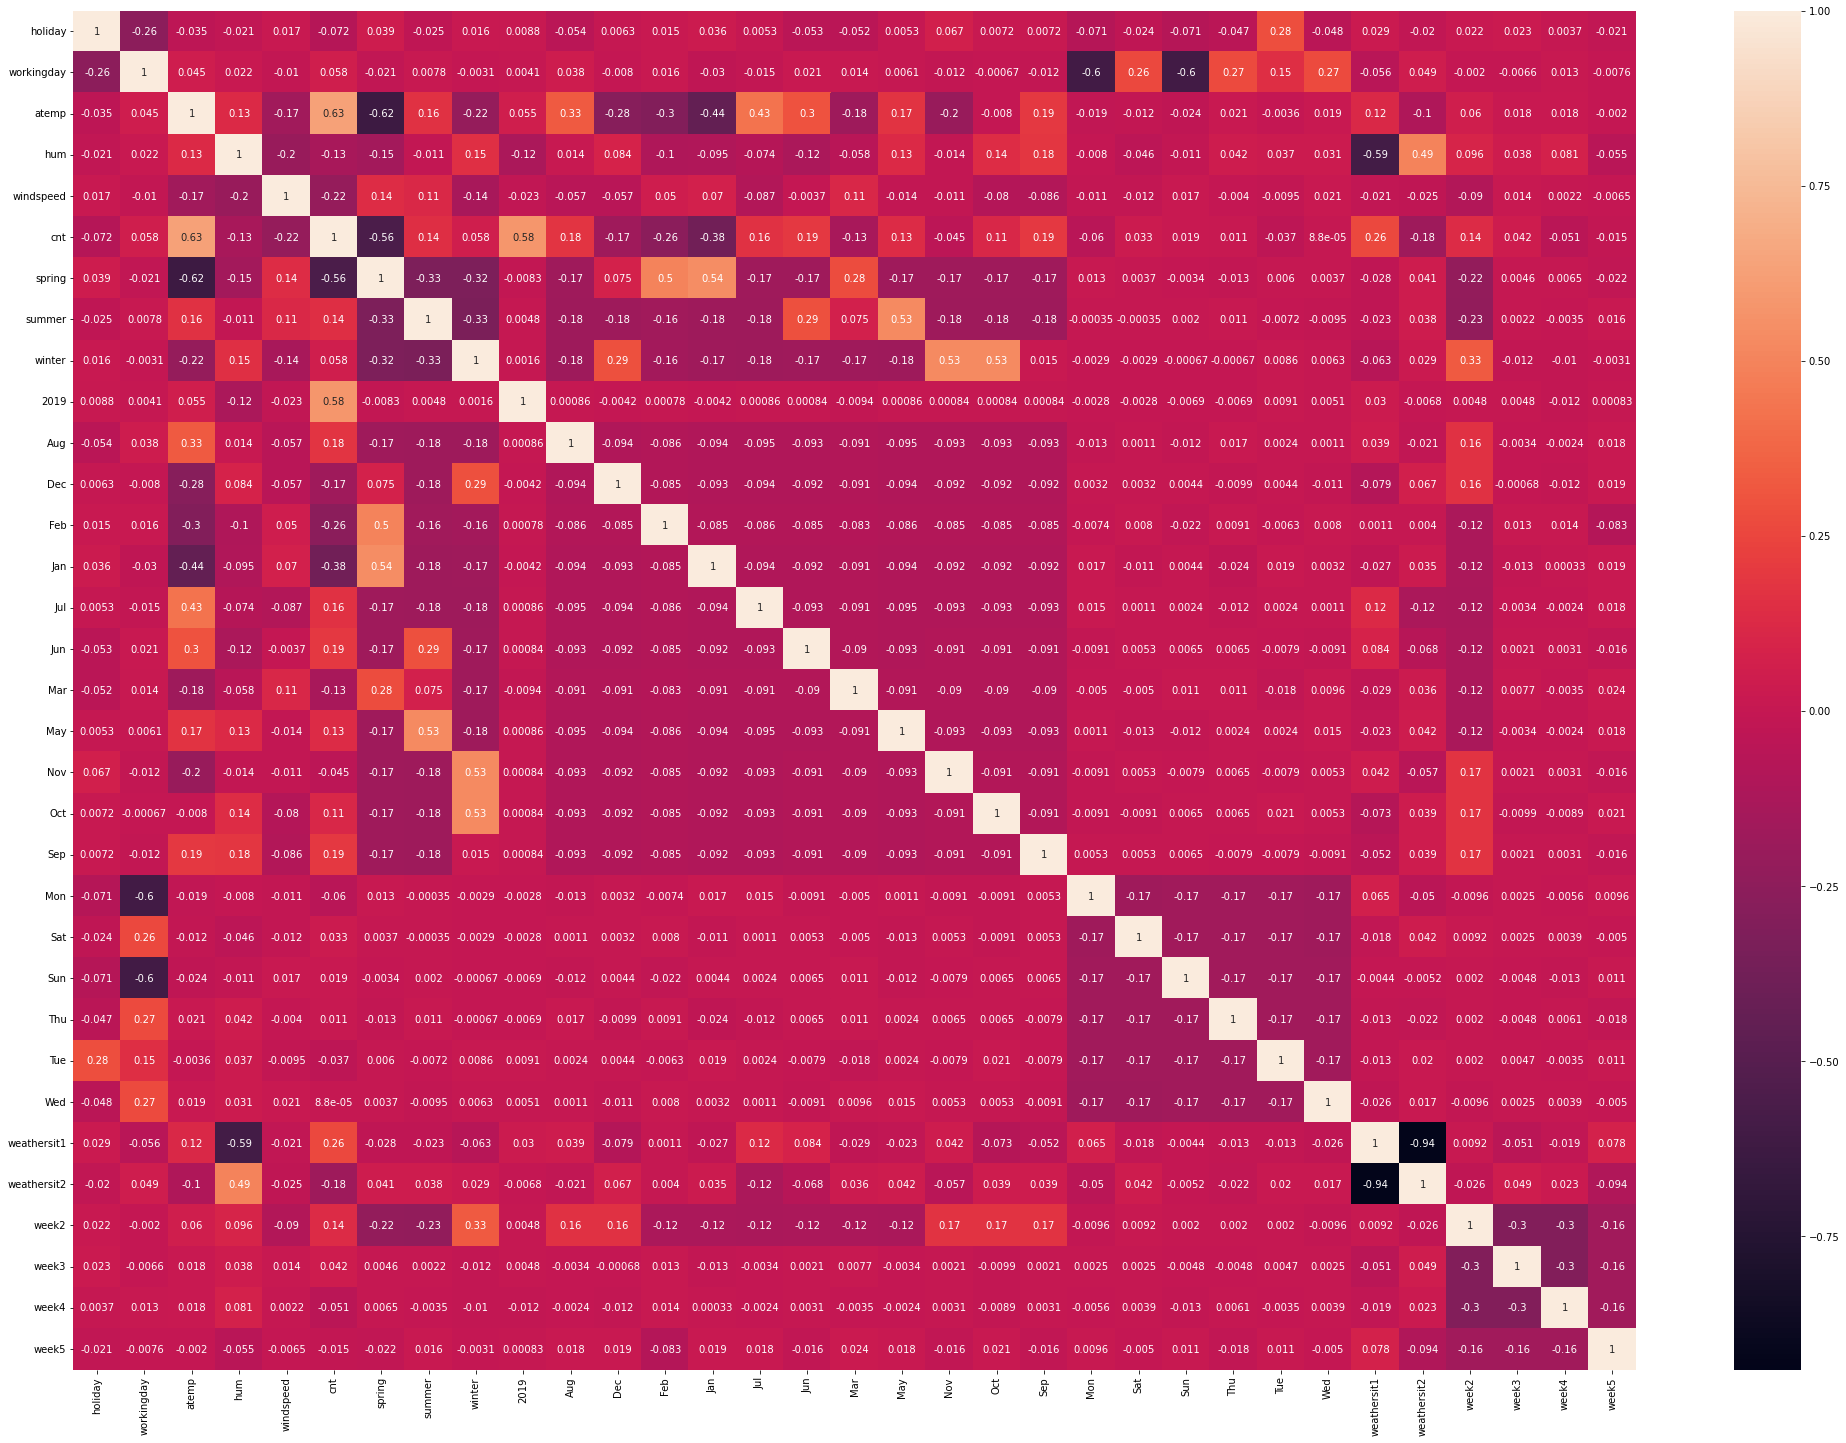

In [18]:
plt.figure(figsize = (35, 25))
sns.heatmap(df2.corr(), annot=True)
plt.show()

# Model Building



Train-test split

In [19]:
np.random.seed(0) # We specify this so that the train and test data set always have the same rows, respectively
df_train, df_test = train_test_split(df2, train_size = 0.8, test_size = 0.2, random_state = 100)

Rescaling

In [20]:
df2

,holiday,workingday,atemp,hum,windspeed,cnt,spring,summer,winter,2019,...,Sun,Thu,Tue,Wed,weathersit1,weathersit2,week2,week3,week4,week5
0,0,0,18.18125,80.5833,10.749882,985,1,0,0,0,...,1,0,0,0,0,1,0,0,0,0
1,0,0,17.68695,69.6087,16.652113,801,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,1,9.47025,43.7273,16.636703,1349,1,0,0,0,...,0,0,1,0,1,0,0,0,0,0
3,0,1,10.60610,59.0435,10.739832,1562,1,0,0,0,...,0,0,0,1,1,0,0,0,0,0
4,0,1,11.46350,43.6957,12.522300,1600,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,0,1,11.33210,65.2917,23.458911,2114,1,0,0,1,...,0,0,0,0,0,1,0,0,1,0
726,0,1,12.75230,59.0000,10.416557,3095,1,0,0,1,...,0,0,0,0,0,1,0,0,1,0
727,0,0,12.12000,75.2917,8.333661,1341,1,0,0,1,...,1,0,0,0,0,1,0,0,0,1
728,0,0,11.58500,48.3333,23.500518,1796,1,0,0,1,...,0,0,0,0,1,0,0,0,0,1


In [21]:
scaler = StandardScaler()
# Apply scaler() to all the continuous variables
num_vars = ['atemp', 'hum', 'windspeed', 'cnt']
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

C:\Python\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Dividing into X and Y

In [22]:
y_train = df_train.pop('cnt')
X_train = df_train

RFE

In [23]:
# Running RFE with the output number of the variable equal to 20
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 20)             # running RFE
rfe = rfe.fit(X_train, y_train)

C:\Python\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=20 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [24]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('holiday', True, 1),
 ('workingday', True, 1),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('spring', True, 1),
 ('summer', True, 1),
 ('winter', True, 1),
 ('2019', True, 1),
 ('Aug', False, 3),
 ('Dec', True, 1),
 ('Feb', True, 1),
 ('Jan', True, 1),
 ('Jul', False, 13),
 ('Jun', False, 4),
 ('Mar', False, 9),
 ('May', True, 1),
 ('Nov', True, 1),
 ('Oct', False, 12),
 ('Sep', True, 1),
 ('Mon', False, 8),
 ('Sat', False, 2),
 ('Sun', True, 1),
 ('Thu', False, 6),
 ('Tue', False, 5),
 ('Wed', False, 11),
 ('weathersit1', True, 1),
 ('weathersit2', True, 1),
 ('week2', True, 1),
 ('week3', True, 1),
 ('week4', False, 10),
 ('week5', False, 7)]

In [25]:
col = X_train.columns[rfe.support_]
X_train.columns[~rfe.support_]

Index(['Aug', 'Jul', 'Jun', 'Mar', 'Oct', 'Mon', 'Sat', 'Thu', 'Tue', 'Wed',
       'week4', 'week5'],
      dtype='object')

Building model using statsmodel, for the detailed statistics

In [26]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]
# Adding a constant variable 
X_train_rfe = sm.add_constant(X_train_rfe)
lm = sm.OLS(y_train,X_train_rfe).fit()   # Running the linear model
print(lm.summary())

C:\Python\lib\site-packages\statsmodels\tsa\tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     168.8
Date:                Wed, 16 Feb 2022   Prob (F-statistic):          8.48e-220
Time:                        11:40:57   Log-Likelihood:                -250.01
No. Observations:                 572   AIC:                             542.0
Df Residuals:                     551   BIC:                             633.4
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.5769      0.125    -12.597      

'summer' is insignificant in presence of other variables; can be dropped

In [27]:
X_train_new = X_train_rfe.drop(["summer"], axis = 1)

Rebuilding the model

In [28]:
X_train_lm = sm.add_constant(X_train_new)
lm = sm.OLS(y_train,X_train_lm).fit()  
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     177.2
Date:                Wed, 16 Feb 2022   Prob (F-statistic):          1.76e-220
Time:                        11:40:57   Log-Likelihood:                -251.09
No. Observations:                 572   AIC:                             542.2
Df Residuals:                     552   BIC:                             629.2
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.5269      0.120    -12.683      

VIF

In [29]:
X_train_new = X_train_new.drop(['const'], axis=1)
# Calculate the VIFs for the new model
vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
15,weathersit1,7.00
5,spring,4.99
1,workingday,4.91
16,weathersit2,3.91
6,winter,3.17
2,atemp,3.16
10,Jan,2.47
7,2019,2.07
9,Feb,1.96
12,Nov,1.91


The VIF of the variable 'weathersit1' is above 5. We will inspecting what would happen if we drop the variable.

In [30]:
X_train_new1 = X_train_new.drop(["weathersit1"], axis = 1)
X_train_lm1 = sm.add_constant(X_train_new1)
lm1 = sm.OLS(y_train,X_train_lm1).fit()  
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     162.3
Date:                Wed, 16 Feb 2022   Prob (F-statistic):          5.17e-207
Time:                        11:40:58   Log-Likelihood:                -286.06
No. Observations:                 572   AIC:                             610.1
Df Residuals:                     553   BIC:                             692.8
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.6191      0.058    -10.613      

C:\Python\lib\site-packages\statsmodels\tsa\tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


After dropping the variable, the new model's adjusted R-squared decreased. Thus, the variable 'weathersit1' is worth keeping. 

# Residual Analysis

In [31]:
y_train_cnt = lm.predict(X_train_lm)

C:\Python\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Errors')

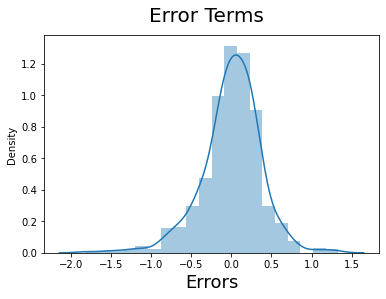

In [32]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_cnt), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

The error terms are also normally distributed with mean zeor. The assumption of linear regression is supported. 

Homoscedasticity

In [33]:
# Define a function calculating residuals
def calculate_residuals(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results

In [34]:
# Define a function showing homoscedasticity of error terms
def homoscedasticity_assumption(model, features, label):
    """
    Homoscedasticity: Assumes that the errors exhibit constant variance
    """
        
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)

    # Plotting the residuals
    plt.subplots(figsize=(12, 6))
    ax = plt.subplot(111)  # To remove spines
    plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
    plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
    ax.spines['right'].set_visible(False)  # Removing the right spine
    ax.spines['top'].set_visible(False)  # Removing the top spine
    plt.title('Residuals')
    plt.show()  

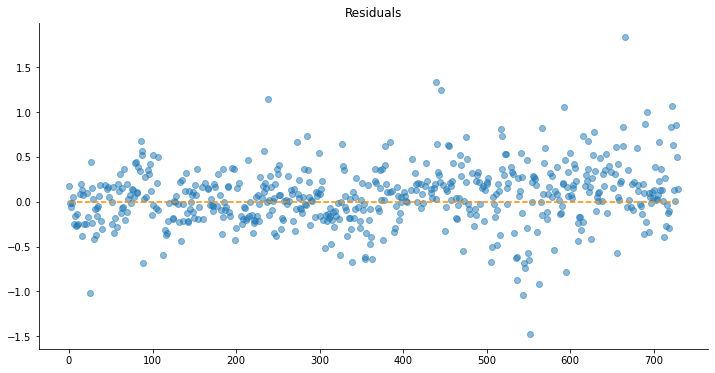

In [35]:
homoscedasticity_assumption(lm, X_train_lm, y_train)

Residuals have relative constant variance. The homoscedasticity assumption is supported.

# Prediction

Rescaling on the test dataset 

In [36]:
num_vars = ['atemp', 'hum', 'windspeed','cnt']

df_test[num_vars] = scaler.transform(df_test[num_vars])

C:\Python\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [37]:
#Dividing into x and y
y_test = df_test.pop('cnt')
X_test = df_test

In [38]:
# Adding constant variable to test dataframe
X_test_m4 = sm.add_constant(X_test)

C:\Python\lib\site-packages\statsmodels\tsa\tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [39]:
#Dropping variables according to the final model
X_test_m4=X_test_m4[['const','holiday', 'workingday', 'atemp', 'hum', 'windspeed', 'spring',
       'winter', '2019', 'Dec', 'Feb', 'Jan', 'May', 'Nov', 'Sep', 'Sun',
       'weathersit1', 'weathersit2', 'week2', 'week3']]

In [40]:
# Making predictions 
y_pred_m4 = lm.predict(X_test_m4)

Model Evaluation

Text(0, 0.5, 'y_pred')

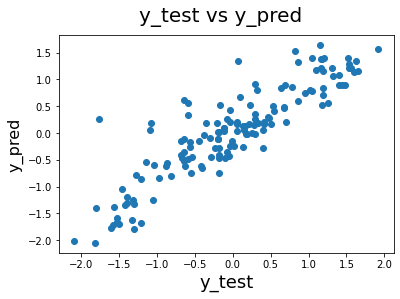

In [41]:
fig = plt.figure()
plt.scatter(y_test, y_pred_m4)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16)      

In [42]:
# Calculating RMSE
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred_m4)))

0.4282354094956198


Model returns a low(good) RMSE

In [44]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred_m4)

0.7918881915055381

Final model: cnt= -1.577 - 0.229*holiday + 0.163*workingday + 0.385*atemp - 0.123*hum -0.101*windspeed - 0.313*spring + 0.093*summer + 0.425*winter + 1.04*2019 - 0.375*Dec - 0.210*Feb - 0.362*Jan +0.130*May - 0.378*Nov + 0.324*Sep + 0.240*Sun + 0.987*weathersit1 + 0.779*weathersit2 + 0.110*week2 + 0.138*week3 